In [2]:
import numpy as np
import torchvision
import torch
import matplotlib.pyplot as plt
from patchify import patchify

%matplotlib inline

In [3]:
# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/home/ventus/.local/lib/python3.12/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [73]:
from torch.utils.data import Dataset
from torch.utils.data import Subset
from sklearn.cluster import KMeans

def patchslice(img, size=4):
	return patchify(np.array(img), (size,size), size).reshape(-1, size * size)

def plot_reconstruction(patches, dataset, dim = None, scale=1):
	dim = dim or 28 // dataset.dim
	patches = patches.reshape(dim, dim)
	fig, axes = plt.subplots(dim, dim, figsize=(6*scale, 6*scale), facecolor='black')
	for arow, prow in zip(axes, patches):
		for ax, patch in zip(arow, prow):
			ax.axis('off')
			ax.imshow(dataset.itop(patch).reshape(dataset.dim, dataset.dim), vmin=0, vmax=255, cmap="Blues")

class ImageDataset(Dataset):    
    def __init__(self, pt_dataset, dim=4, clusters=400):
        self.pt_dataset = pt_dataset

        patches = np.vstack([patchslice(sample[0], size=dim) for sample in pt_dataset])
        self.kclassifier = KMeans(n_clusters=clusters).fit(patches)
        self.dim = dim
        self.vocab_size = clusters

        self.itop = lambda i: self.kclassifier.cluster_centers_[i]
        self.ptoi = lambda p: self.kclassifier.predict(p)
        self.block_size = (28 // dim)**2 - 1
        
    def __len__(self):
        return len(self.pt_dataset)

    def __getitem__(self, idx):
        x, y = self.pt_dataset[idx]
        # p = np.round(patchslice(np.array(x), size=self.size) / (255 / (self.base - 1)))
        p = self.ptoi(patchslice(x, size=self.dim))
        p = torch.from_numpy(p).long()
        return p[:-1],p[1:] # always just predict the next one in the sequence


train_data = torchvision.datasets.MNIST('./', train=True, transform=None, target_transform=None, download=True)
train_dataset = ImageDataset(Subset(train_data, [i for i, (img, label) in enumerate(train_data) if label == 5]))

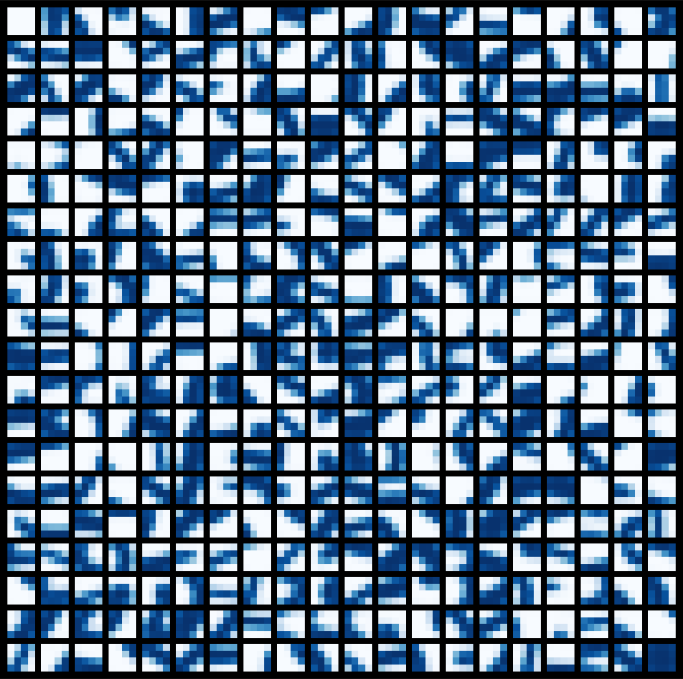

In [74]:
plot_reconstruction(np.arange(400), train_dataset, dim = 20, scale=2)

In [81]:
from mingpt.model import GPT

model = GPT(
	train_dataset.vocab_size,
	train_dataset.block_size,
    embd_pdrop=0.1,
	resid_pdrop=0.1,
	attn_pdrop=0.1,
    n_layer=6,
	n_head=1,
	n_embd=128
)

number of parameters: 1.25M


In [82]:
from mingpt.trainer import Trainer

training_parameters = dict(
    batch_size = 16,
    max_iters = 5000,
    learning_rate = 2e-4,
    betas = (0.9, 0.95),
    weight_decay = 0.1,
    grad_norm_clip = 1.0,
    device = device,
    num_workers = 16,
)

def batch_end_callback(trainer):
    if trainer.iter_num % 500 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
        inp = torch.tensor([0])[None,...].to(trainer.device)
        out = model.generate(idx=inp, max_new_tokens=train_dataset.block_size, temperature=1, do_sample=True, top_k=train_dataset.vocab_size // 4)

        plot_reconstruction(out, train_dataset)
        plt.show()


## Training

running on device cpu
iter_dt 0.00ms; iter 0: train loss 5.95703


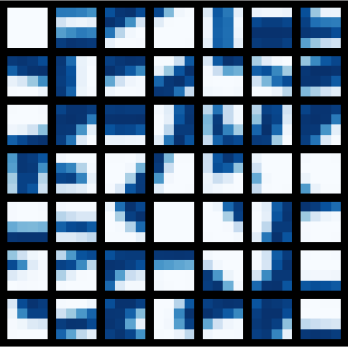

iter_dt 46.47ms; iter 500: train loss 1.81492


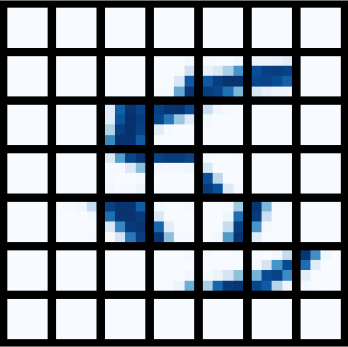

iter_dt 54.77ms; iter 1000: train loss 1.74781


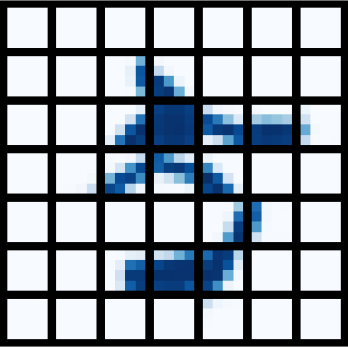

iter_dt 52.10ms; iter 1500: train loss 1.54268


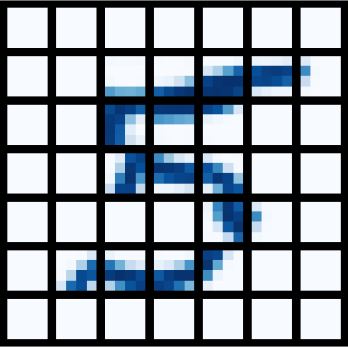

iter_dt 43.48ms; iter 2000: train loss 1.50822


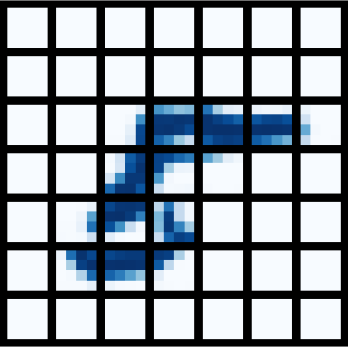

iter_dt 46.34ms; iter 2500: train loss 1.38594


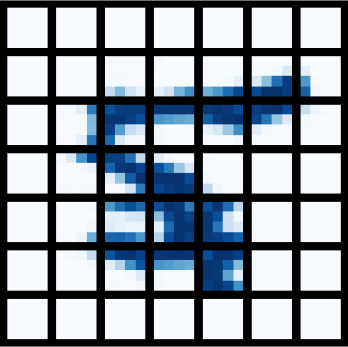

iter_dt 44.60ms; iter 3000: train loss 1.46985


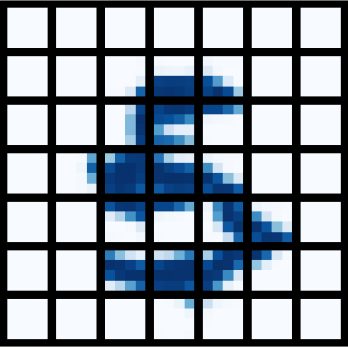

iter_dt 44.36ms; iter 3500: train loss 1.29017


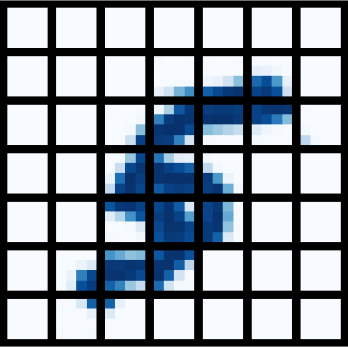

iter_dt 48.80ms; iter 4000: train loss 1.43391


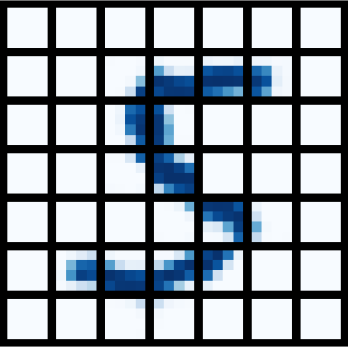

iter_dt 45.00ms; iter 4500: train loss 1.22662


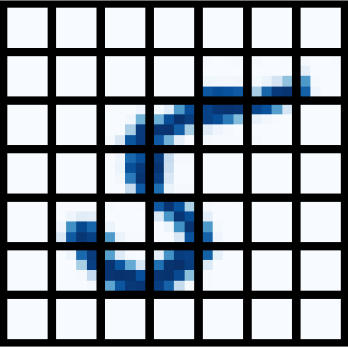

In [83]:
# initialize a trainer instance and kick off training
trainer = Trainer(model, train_dataset, **training_parameters)
trainer.set_callback('on_batch_end', batch_end_callback)
trainer.run()